<>:24: SyntaxWarning: invalid escape sequence '\('
<>:24: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-3472912852.py:24: SyntaxWarning: invalid escape sequence '\('
  mask = ~df.columns.str.contains("src|\(\d+\)|Unnamed|placeholder|image|carousel", regex=True, case=False)


Done. Matches found: 16


,Amazon_idx,Noon_idx,Amazon_Product,Amazon_Price,Noon_Product,Noon_Price,Match_Score,Price_Difference,Best_Option
0,0,0,Maybelline New York Fit Me Matte + Poreless FO...,525.00,MAYBELLINE NEW YORK Maybelline New York Fit Me...,374.95,100.000000,150.05,Noon
1,3,42,Bourjois AIR MAT FOUNDATION - 01 ROSE IVORY,520.00,BOURJOIS PARIS Air Mat 24H Foundation 01 Rose ...,599.00,100.000000,-79.00,Amazon
2,12,8,Dermatique Maquillage Corrective Foundation - ...,299.00,"Dermatique Maquillage Corrective Foundation, L...",177.20,100.000000,121.80,Noon
3,42,14,essence NATURAL MATTE MOUSSE FOUNDATION 13,362.98,Essence Natural Matte Mousse Foundation Beige 13,363.00,100.000000,-0.02,Amazon
4,36,2,DISAAR Beauty Vitamin C Waterproof Whitening F...,149.00,Disaar Vitamin C Waterproof Whitening Foundation,99.05,100.000000,49.95,Noon
5,6,26,L'Oréal Paris Infaillible 24H Fresh Wear Found...,684.00,L'OREAL PARIS Infaillible 24H Fresh Wear Found...,715.00,97.540984,-31.00,Amazon
6,13,14,essence NATURAL MATTE MOUSSE FOUNDATION 04,294.98,Essence Natural Matte Mousse Foundation Beige 13,363.00,96.296296,-68.02,Amazon
7,22,45,Sheglam Skin Focus High Coverage Powder Founda...,642.99,SHEGLAM Skin Focus High Coverage Powder Founda...,610.00,95.238095,32.99,Noon
8,14,26,L'Oréal Paris Infaillible 24H Fresh Wear Found...,689.00,L'OREAL PARIS Infaillible 24H Fresh Wear Found...,715.00,93.449782,-26.00,Amazon
9,18,26,L'Oréal Paris Infaillible 24H Fresh Wear Found...,649.00,L'OREAL PARIS Infaillible 24H Fresh Wear Found...,715.00,93.449782,-66.00,Amazon


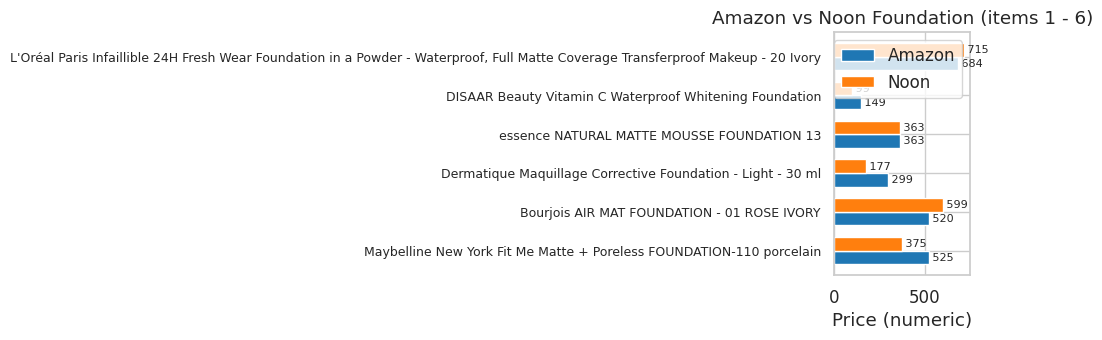

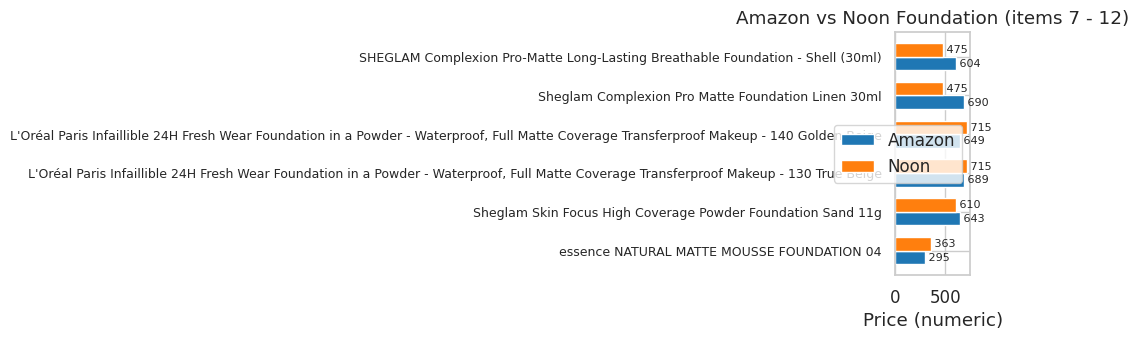

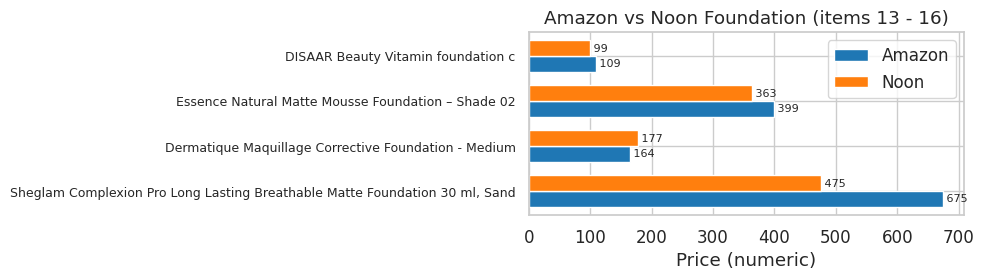

Saved: amazon_foundation_cleaned_snapshot.csv, noon_foundation_cleaned_snapshot.csv, Amazon_vs_Noon_foundation_comparison.csv/xlsx


In [2]:
!pip install rapidfuzz --quiet

import pandas as pd, numpy as np, re
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.1)

# تحديث أسماء الملفات لتتناسب مع ملفات الفاونديشن
AMAZON_FILE = "amazon_Foundation.csv"
NOON_FILE   = "noon_Foundation.csv"
MATCH_THRESHOLD = 85
BATCH_SIZE = 6

# قراءة الملفات
amazon = pd.read_csv(AMAZON_FILE)
noon   = pd.read_csv(NOON_FILE)

# حفظ نسخة احتياطية
amazon.to_csv("amazon_foundation_backup_before_clean.csv", index=False)
noon.to_csv("noon_foundation_backup_before_clean.csv", index=False)

def drop_junk_cols(df):
    mask = ~df.columns.str.contains("src|\(\d+\)|Unnamed|placeholder|image|carousel", regex=True, case=False)
    return df.loc[:, mask]

def find_column_like(df, patterns):
    cols = df.columns.tolist()
    for p in patterns:
        for c in cols:
            if p.lower() in c.lower():
                return c
    text_cols = [c for c in cols if df[c].dtype == object]
    if text_cols:
        avg_len = {c: df[c].astype(str).map(len).mean() for c in text_cols}
        best = max(avg_len, key=avg_len.get)
        return best
    return None

def clean_numeric_series(s):
    s = s.astype(str).str.replace(",", "", regex=False).str.strip()
    extracted = s.str.extract(r"([0-9]+(?:\.[0-9]+)?)")[0]
    return pd.to_numeric(extracted, errors="coerce")

def normalize_product_name(s):
    s = str(s).lower()
    s = re.sub(r"package(ing)? may vary", " ", s)
    s = re.sub(r"\b(\d+\s*(ml|g|gm|kg|l|oz|cm|mm))\b", " ", s)
    s = re.sub(r"\b(ml|g|gm|kg|l|oz|pack|packs|pcs|piece|pieces|box|set)\b", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# تنظيف الأعمدة غير الضرورية
amazon = drop_junk_cols(amazon)
noon = drop_junk_cols(noon)

# تحديد الأعمدة في بيانات الأمازون (بناءً على هيكل ملف الفاونديشن)
a_product_col = "Product_Name"  # اسم العمود الموجود في ملف الأمازون
a_price_col = "Price"           # اسم عمود السعر في ملف الأمازون
a_rating_col = "Rating"         # اسم عمود التقييم في ملف الأمازون
a_reviews_col = "Reviews"       # اسم عمود المراجعات في ملف الأمازون

# تحديد الأعمدة في بيانات نون (بناءً على هيكل ملف الفاونديشن)
n_product_col = "Product_Name"  # اسم العمود الموجود في ملف نون
n_price_col = "Price"           # اسم عمود السعر في ملف نون
n_rating_col = "Rating"         # اسم عمود التقييم في ملف نون
n_reviews_col = "Reviews"       # اسم عمود المراجعات في ملف نون

# تنظيف بيانات الأمازون
amazon_clean = pd.DataFrame()
amazon_clean['Product_raw'] = amazon[a_product_col]
amazon_clean['Price_raw'] = amazon[a_price_col]
amazon_clean['Rating_raw'] = amazon[a_rating_col]
amazon_clean['Reviews_raw'] = amazon[a_reviews_col]

# تنظيف بيانات نون
noon_clean = pd.DataFrame()
noon_clean['Product_raw'] = noon[n_product_col]
noon_clean['Price_raw'] = noon[n_price_col]
noon_clean['Rating_raw'] = noon[n_rating_col]
noon_clean['Reviews_raw'] = noon[n_reviews_col]

# تطبيع أسماء المنتجات
amazon_clean['Product_norm'] = amazon_clean['Product_raw'].fillna("").map(normalize_product_name)
noon_clean['Product_norm'] = noon_clean['Product_raw'].fillna("").map(normalize_product_name)

# تنظيف البيانات الرقمية
amazon_clean['Price'] = clean_numeric_series(amazon_clean['Price_raw'])
amazon_clean['Rating'] = clean_numeric_series(amazon_clean['Rating_raw'])
amazon_clean['Reviews'] = clean_numeric_series(amazon_clean['Reviews_raw'])

noon_clean['Price'] = clean_numeric_series(noon_clean['Price_raw'])
noon_clean['Rating'] = clean_numeric_series(noon_clean['Rating_raw'])
noon_clean['Reviews'] = clean_numeric_series(noon_clean['Reviews_raw'])

# حفظ البيانات المنظفة
amazon_clean.to_csv("amazon_foundation_cleaned_snapshot.csv", index=False)
noon_clean.to_csv("noon_foundation_cleaned_snapshot.csv", index=False)

# المقارنة بين المنتجات
noon_choices = noon_clean['Product_norm'].fillna("").tolist()
results = []
for idx, row in amazon_clean.iterrows():
    a_name = row['Product_norm']
    if not a_name.strip():
        continue
    match = process.extractOne(a_name, noon_choices, scorer=fuzz.token_set_ratio)
    if match is None:
        continue
    best_name, score, match_index = match
    if score < MATCH_THRESHOLD:
        continue
    n_row = noon_clean.iloc[match_index]
    a_price = row['Price'] if not pd.isna(row['Price']) else np.nan
    n_price = n_row['Price'] if not pd.isna(n_row['Price']) else np.nan
    price_diff = (a_price - n_price) if (not np.isnan(a_price) and not np.isnan(n_price)) else np.nan
    if np.isnan(price_diff):
        if not np.isnan(a_price) and np.isnan(n_price):
            best_opt = "Amazon"
        elif np.isnan(a_price) and not np.isnan(n_price):
            best_opt = "Noon"
        else:
            best_opt = "Unknown"
    else:
        best_opt = "Amazon" if a_price < n_price else "Noon"

    results.append({
        "Amazon_idx": idx,
        "Noon_idx": match_index,
        "Amazon_Product": row['Product_raw'],
        "Amazon_Price": a_price,
        "Noon_Product": n_row['Product_raw'],
        "Noon_Price": n_price,
        "Match_Score": score,
        "Price_Difference": price_diff,
        "Best_Option": best_opt
    })

comparison = pd.DataFrame(results).sort_values("Match_Score", ascending=False).reset_index(drop=True)
comparison.to_csv("Amazon_vs_Noon_foundation_comparison.csv", index=False)
comparison.to_excel("Amazon_vs_Noon_foundation_comparison.xlsx", index=False)

print("Done. Matches found:", len(comparison))
display(comparison.head(50))

def plot_batches(df, batch_size=4, amazon_col="Amazon_Price", noon_col="Noon_Price"):
    names = df["Amazon_Product"].astype(str).tolist()
    a_prices = df[amazon_col].tolist()
    n_prices = df[noon_col].tolist()
    for i in range(0, len(names), batch_size):
        batch_names = names[i:i+batch_size]
        batch_a = a_prices[i:i+batch_size]
        batch_n = n_prices[i:i+batch_size]
        y = np.arange(len(batch_names))
        height = 0.35
        plt.figure(figsize=(10, max(3, len(batch_names)*0.6)))
        plt.barh(y - height/2, batch_a, height=height, label="Amazon", color="#1f77b4")
        plt.barh(y + height/2, batch_n, height=height, label="Noon", color="#ff7f0e")
        plt.yticks(y, batch_names, fontsize=9)
        plt.xlabel("Price (numeric)")
        plt.title(f"Amazon vs Noon Foundation (items {i+1} - {i+len(batch_names)})")
        for yi, av, nv in zip(y, batch_a, batch_n):
            if not pd.isna(av):
                plt.text(av, yi - height/2, f" {av:.0f}", va="center", fontsize=8)
            if not pd.isna(nv):
                plt.text(nv, yi + height/2, f" {nv:.0f}", va="center", fontsize=8)
        plt.legend()
        plt.tight_layout()
        plt.show()

if not comparison.empty:
    plot_df = comparison.sort_values("Match_Score", ascending=False).reset_index(drop=True)
    plot_batches(plot_df, batch_size=BATCH_SIZE)

print("Saved: amazon_foundation_cleaned_snapshot.csv, noon_foundation_cleaned_snapshot.csv, Amazon_vs_Noon_foundation_comparison.csv/xlsx")